In [ ]:
# Dartsで生成される通知を減らす
import warnings
import logging

# warnings.filterwarnings("ignore")
logging.disable(logging.CRITICAL)

# 数値計算に使うライブラリ
import numpy as np
import pandas as pd

# グラフを描画するライブラリ
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

sns.set()

# データ読み込みに利用
import statsmodels.api as sm

# sktime：グラフ描画
from sktime.utils.plotting import plot_series

# sktime：予測
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster

# sktime：予測の評価指標
from sktime.performance_metrics.forecasting import (
    mean_absolute_scaled_error,
    MeanAbsoluteError,
    mean_absolute_percentage_error,
    mean_absolute_error,
)

# sktime：予測の評価
from sktime.forecasting.model_selection import (
    temporal_train_test_split,
    ExpandingWindowSplitter,
    ForecastingGridSearchCV,
)
from sktime.forecasting.model_evaluation import evaluate

# sktime：データの変換
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.boxcox import LogTransformer
from sklearn.preprocessing import StandardScaler
from sktime.transformations.series.adapt import TabularToSeriesAdaptor

# sktime：パイプライン
from sktime.forecasting.compose import TransformedTargetForecaster, MultiplexForecaster
from sktime.pipeline import make_pipeline
from sktime.transformations.compose import OptionalPassthrough

# 機械学習法
from sklearn.neural_network import MLPRegressor
import lightgbm as lgb

# 再帰的に回帰分析を実行するための関数の読み込み
from sktime.forecasting.compose import make_reduction

# Darts関連
from darts import TimeSeries
from darts.models import RNNModel

# グラフの日本語表記
from matplotlib import rcParams

rcParams["font.family"] = "IPAexGothic"
rcParams["font.sans-serif"] = "Meiryo"

In [2]:
# 表示設定
np.set_printoptions(linewidth=60)
pd.set_option("display.width", 80)

from matplotlib.pylab import rcParams

rcParams["figure.figsize"] = 8, 4

Text(0.5, 1.0, 'ReLU')

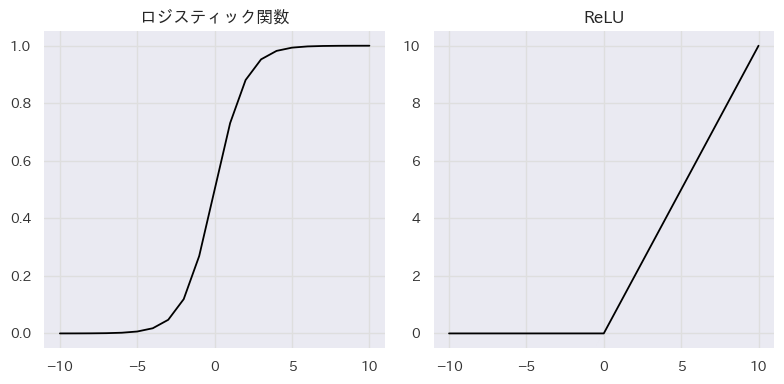

In [3]:
# 教科書の図の作成

# 活性化関数を適用させる対象
x = np.arange(-10, 11)


# ロジスティック関数
def logistic(u):
    return 1 / (1 + np.exp(-u))


# ReLU
def relu(u):
    return np.maximum(0, u)


# 2行のグラフを作る
fig, ax = plt.subplots(figsize=(8, 4), ncols=2, tight_layout=True)

# ロジスティック関数の折れ線グラフ
ax[0].plot(x, logistic(x))
ax[0].set_title("ロジスティック関数")

# ReLUの折れ線グラフ
ax[1].plot(x, relu(x))
ax[1].set_title("ReLU")

In [4]:
# 飛行機乗客数データの読み込み
air_passengers = sm.datasets.get_rdataset("AirPassengers").data

# 日付インデックスの作成(PeriodIndex)
date_index = pd.period_range(start="1949-01", periods=len(air_passengers), freq="M")
air_passengers.index = date_index

# 不要な時間ラベルの削除
air_passengers = air_passengers.drop(air_passengers.columns[0], axis=1)

In [5]:
# 訓練データとテストデータに分割する
train_air, test_air = temporal_train_test_split(air_passengers, test_size=36)

# 予測期間
fh_air = np.arange(1, len(test_air) + 1)

In [6]:
# ==========================================================
# 前処理パイプラインの設定（Detrender + 標準化）
# ==========================================================

# sktimeのmake_pipelineを利用して、複数の前処理を順に適用する。
# - Detrender：トレンド（傾向）成分を除去する
# - StandardScaler：スケーリングにより数値スケールを標準化
#
# この処理により、機械学習モデルが
# 「トレンドやスケールの影響を受けずに」
# データの変動パターンをより正確に学習できるようになる。
# ==========================================================
pipe_transform = make_pipeline(
    # ------------------------------------------------------
    # 1. トレンド除去（Detrender）
    # ------------------------------------------------------
    # PolynomialTrendForecaster を内部で利用し、
    # データ系列のトレンドを多項式で近似・除去する。
    #
    # model='multiplicative' の場合：
    #   y_t = T_t × ε_t  →  ε_t = y_t / T_t
    #   （乗法モデル：変化率的なトレンド除去）
    #
    # model='additive' の場合：
    #   y_t = T_t + ε_t  →  ε_t = y_t - T_t
    #   （加法モデル：差分的なトレンド除去）
    #
    # ここでは、時系列データの変動幅が時間とともに
    # 拡大するような“非定常な系列”を想定しており、
    # 乗法モデルによる除去が適している。
    # ------------------------------------------------------
    Detrender(
        forecaster=PolynomialTrendForecaster(degree=1),  # 一次（線形）トレンドを想定
        model="multiplicative",  # 乗法的トレンド除去
    ),
    # ------------------------------------------------------
    # 2. 標準化（StandardScaler）
    # ------------------------------------------------------
    # 各系列を「平均0・標準偏差1」に変換し、
    # 特徴量のスケールを統一する。
    #
    # sktimeでは、StandardScalerは直接Seriesに適用できないため、
    # TabularToSeriesAdaptorでラップして利用する。
    #
    # この変換により：
    #   ・特徴量の単位差による学習バイアスを防ぐ
    #   ・勾配ベースの学習（例：LightGBM, XGBoost）や
    #     距離尺度を用いるアルゴリズム（例：KNN, SVM）が安定化
    # ------------------------------------------------------
    TabularToSeriesAdaptor(StandardScaler()),
)

In [7]:
# ==============================================================
# 予測器（多層パーセプトロン：Neural Network Regressor）
# ==============================================================

# scikit-learnのMLPRegressorを利用して、非線形回帰モデルを構築する。
# このモデルは多層パーセプトロン（Multi-Layer Perceptron, MLP）を基盤とする
# フィードフォワード型ニューラルネットワークである。
#
# - hidden_layer_sizes: 隠れ層のユニット数を指定
#     (100, 100) → 2層構造で各層に100ノードを持つ
# - max_iter: 収束までの最大反復回数（勾配降下の反復回数）
# - random_state: 乱数シード（再現性確保のため）
# --------------------------------------------------------------
nn_regressor = MLPRegressor(
    hidden_layer_sizes=(100, 100),  # 非線形特徴を2層で表現
    max_iter=2000,  # 十分なエポック数
    random_state=1,  # 再現性確保
)

# ==============================================================
# 前処理 → ニューラルネットによる予測 の統合パイプライン
# ==============================================================

# TransformedTargetForecaster を使うことで、目的変数の前処理から
# モデル適用・逆変換までを統合的に扱うことができる。
#
# 構成要素:
#   1️⃣ pipe_transform（前処理段階）
#        - トレンド除去（Detrender）
#        - 標準化（StandardScaler）
#   2️⃣ make_reduction()（時系列を教師あり学習形式に変換）
#        - window_length=12 → 過去12時点を入力として次時点を予測
#        - strategy="recursive" → 予測結果を次の入力に再利用（自己回帰的）
# --------------------------------------------------------------
pipe_nn = TransformedTargetForecaster(
    steps=[
        # ① 前処理ステップ
        pipe_transform,
        # ② ニューラルネットワーク回帰器
        (
            "forecast",
            make_reduction(
                nn_regressor,  # 上で定義したMLPモデル
                window_length=12,  # 入力として利用する時系列の長さ
                strategy="recursive",  # 再帰的に次の時点を予測
            ),
        ),
    ]
)

# ==============================================================
# データへの当てはめ（学習）
# ==============================================================

# fit()では以下の流れが自動的に実行される：
# 1. train_air の時系列データに対してトレンド除去と標準化を実施。
# 2. 教師データを「過去12点 → 次の1点」の形式に変換。
# 3. ニューラルネットワーク（MLP）が最適な重みを学習。
# --------------------------------------------------------------
pipe_nn.fit(train_air)

TransformedTargetForecaster(steps=[TransformerPipeline(steps=[Detrender(forecaster=PolynomialTrendForecaster(),
                                                                        model='multiplicative'),
                                                              TabularToSeriesAdaptor(transformer=StandardScaler())]),
                                   ('forecast',
                                    RecursiveTabularRegressionForecaster(estimator=MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=2000, random_state=1),
                                                                         window_length=12))])

In [8]:
# 予測の実施
pipe_nn_pred = pipe_nn.predict(fh_air)

# 予測精度
mae = mean_absolute_error(test_air, pipe_nn_pred)
mase = mean_absolute_scaled_error(test_air, pipe_nn_pred, y_train=train_air)

print("MAE :", mae)
print("MASE:", mase)

MAE : 19.930134227125887
MASE: 0.980921969780345


In [14]:
# 前処理
transed = pipe_transform.fit_transform(train_air)

# DataFrame内の数値列をfloat32に変換
transed = transed.astype({"value": "float32"})

# dartsのために日付列を追加
transed["time"] = transed.index.to_timestamp()

# 結果の確認
print(transed.head(3))

            value       time
1949-01  1.005337 1949-01-01
1949-02  1.227183 1949-02-01
1949-03  1.990141 1949-03-01


In [15]:
# dartsのためのデータ
TimeSeries.from_dataframe(transed, time_col="time", value_cols="value").head(3)

<TimeSeries (DataArray) (time: 3, component: 1, sample: 1)> Size: 12B
array([[[1.0053369]],

       [[1.2271825]],

       [[1.9901408]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 24B 1949-01-01 1949-02-01 1949-03-01
  * component  (component) object 8B 'value'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [16]:
# 参考：データの型
type(TimeSeries.from_dataframe(transed, time_col="time", value_cols="value").head(3))

darts.timeseries.TimeSeries

In [17]:
params = {
    "hidden_dim": 100,  # 隠れ層のユニットの数
    "n_epochs": 300,  # エポックの数
    "random_state": 1,  # 乱数の種
    "input_chunk_length": 12,  # 予測時に渡される過去の時間ステップの数
    "training_length": 24,  # 学習時に用いられる訓練データの長さ
}

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


<Axes: xlabel='time'>

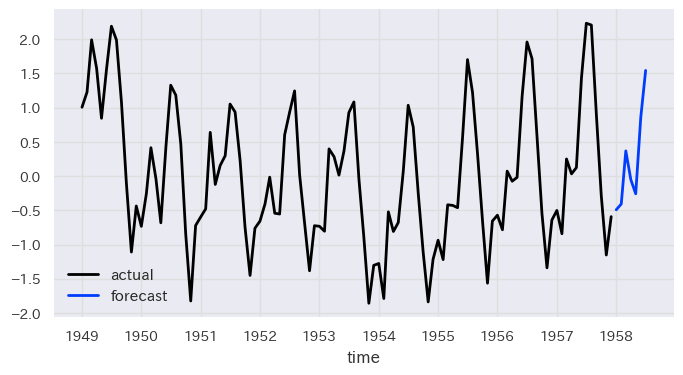

In [18]:
# -*- coding: utf-8 -*-
# ============================================================
# RNNモデルを用いた時系列データの学習コード
# ライブラリ: Darts (u8darts)
# 目的: DataFrameからTimeSeriesを生成し、RNNで学習を行う
# ============================================================

# ------------------------------------------------------------
# モデルパラメータ設定（例示）
# ------------------------------------------------------------
params = {
    "input_chunk_length": 24,  # 入力する過去データの長さ（過去24ステップ分を使って予測）
    "output_chunk_length": 1,  # 予測する未来データの長さ（1ステップ先を予測）
    "n_epochs": 200,  # 学習エポック数
    "hidden_dim": 32,  # RNNの隠れ層ユニット数
    "optimizer_kwargs": {"lr": 1e-3},  # 学習率などのオプティマイザ設定
    "batch_size": 16,  # ミニバッチサイズ
    "model_name": "rnn_forecast",  # モデルの識別名（保存用）
    "random_state": 42,  # 再現性確保のための乱数シード
}

# ------------------------------------------------------------
# モデルの設定
# ------------------------------------------------------------
mod_rnn = RNNModel(
    model="RNN",  # 使用するモデルタイプ（"RNN", "LSTM", "GRU"などを指定可能）
    **params  # 上で定義したパラメータを展開して渡す
)

# ------------------------------------------------------------
# データの準備
# ------------------------------------------------------------
# 'transed' は pandas DataFrame を想定
# - time_col : 時間を表す列（日時データ）
# - value_cols : 予測対象となる値（例: 売上, 気温, トラフィックなど）
series = TimeSeries.from_dataframe(
    transed,  # 学習用DataFrame
    time_col="time",  # 時間列
    value_cols="value",  # 予測対象列
)

# ------------------------------------------------------------
# モデルの学習
# ------------------------------------------------------------
# fit() により、RNNモデルを時系列データに当てはめて学習を行う
# verbose=True により、学習過程（損失の変化など）が出力される
mod_rnn.fit(series, verbose=True)

# ------------------------------------------------------------
# （任意）予測例
# ------------------------------------------------------------
# n=7 とすると、7ステップ先（例: 7日先）の予測を行う
forecast = mod_rnn.predict(n=7)

# 予測結果の可視化（実データと予測値を比較）
series.plot(label="actual")
forecast.plot(label="forecast")

In [19]:
# 予測
rnn_pred = mod_rnn.predict(n=36)

# 整形
rnn_pred = rnn_pred.pd_dataframe()
rnn_pred.index = rnn_pred.index.to_period()

# 変換をもとに戻す
rnn_pred = pipe_transform.inverse_transform(rnn_pred)

# 結果の確認
print(rnn_pred.head(3))

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.51it/s]
component       value
time                 
1958-01    343.458788
1958-02    350.225226
1958-03    393.343439


In [20]:
# 予測精度
mae = mean_absolute_error(test_air, rnn_pred)
mase = mean_absolute_scaled_error(test_air, rnn_pred, y_train=train_air)

print("MAE :", mae)
print("MASE:", mase)

MAE : 25.917933651270758
MASE: 1.2756296691287816


In [21]:
# モデルの設定
mod_lstm = RNNModel(model="LSTM", **params)

# 当てはめ
mod_lstm.fit(
    TimeSeries.from_dataframe(transed, time_col="time", value_cols="value"),
    verbose=True,
)

Epoch 199: 100%|██████████| 6/6 [00:00<00:00, 156.67it/s, train_loss=0.0727]


RNNModel(model=LSTM, hidden_dim=32, n_rnn_layers=1, dropout=0.0, training_length=24, input_chunk_length=24, output_chunk_length=1, n_epochs=200, optimizer_kwargs={'lr': 0.001}, batch_size=16, model_name=rnn_forecast, random_state=42)

In [22]:
# 予測
lstm_pred = mod_lstm.predict(n=36)

# 整形
lstm_pred = lstm_pred.pd_dataframe()
lstm_pred.index = lstm_pred.index.to_period()

# 変換をもとに戻す
lstm_pred = pipe_transform.inverse_transform(lstm_pred)

# 結果の確認
print(lstm_pred.head(3))

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]
component       value
time                 
1958-01    353.995976
1958-02    352.021914
1958-03    398.011360


In [23]:
# 予測精度
mae = mean_absolute_error(test_air, lstm_pred)
mase = mean_absolute_scaled_error(test_air, lstm_pred, y_train=train_air)

print("MAE :", mae)
print("MASE:", mase)

MAE : 33.52614212101806
MASE: 1.6500907115680463


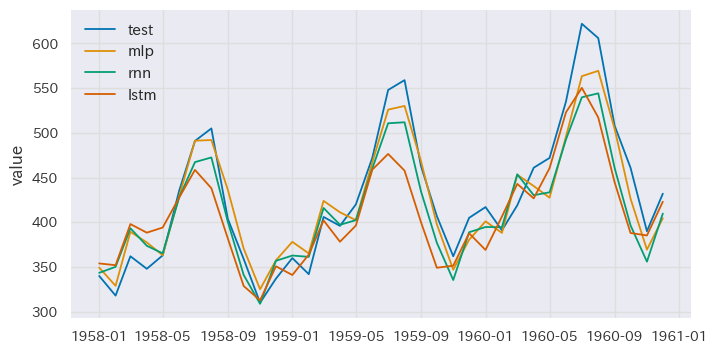

In [24]:
# 予測結果の可視化
fig, ax = plot_series(
    test_air,
    pipe_nn_pred,
    rnn_pred,
    lstm_pred,
    labels=["test", "mlp", "rnn", "lstm"],
    markers=np.tile("", 4),
)
fig.set_size_inches(8, 4)